In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import sql
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder

In [2]:
text_columns = ['agency_name', 'agency_abbr', 'loan_type_name', 'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'preapproval_name', 'action_taken_name', 'msamd_name', 'state_name', 'state_abbr', 'county_name', 'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1', 'co_applicant_race_name_1', 'applicant_sex_name', 'co_applicant_sex_name', 'purchaser_type_name', 'hoepa_status_name', 'lien_status_name', 'application_id']
numeric_columns = ['agency_code', 'loan_type', 'property_type', 'loan_purpose', 'owner_occupancy', 'loan_amount_000s', 'preapproval', 'action_taken', 'msamd', 'state_code', 'county_code', 'census_tract_number', 'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1', 'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex', 'applicant_income_000s', 'purchaser_type', 'hoepa_status', 'lien_status', 'population', 'minority_population', 'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'application_id']

### Set Up connection to AWS RDS

In [3]:
PGEND_POINT = 'hmda-final-db.cfo8yzx2osax.us-east-1.rds.amazonaws.com' # End_point
PGDATABASE_NAME = 'hmda_db' # Database Name example: youtube_test_db
PGUSER_NAME = 'postgres' # UserName
PGPASSWORD = 'Password' # Password

In [4]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ PGEND_POINT +" port="+ "5432" +" dbname="+ PGDATABASE_NAME +" user=" + PGUSER_NAME \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [5]:
conn, cursor = connect()

Connected!


### Query Machine Learning Dataset
Machine Learning Dataset will include categorical applicant/loan information, census data, and categoric

In [6]:
query = sql.SQL('''
SELECT 
    nd.loan_amount_000s,
    nd.applicant_income_000s,
    nd.population,
    nd.minority_population,
    nd.census_tract_number,
    nd.hud_median_family_income,
    nd.tract_to_msamd_income,
    nd.number_of_owner_occupied_units,
    nd.number_of_1_to_4_family_units,
    td.agency_abbr, 
    td.loan_type_name, 
    td.property_type_name, 
    td.loan_purpose_name,
    td.owner_occupancy_name, 
    td.msamd_name,
    td.county_name,
    td.preapproval_name,
    nd.preapproval,
    td.action_taken_name,
    nd.action_taken
FROM
    numeric_data nd 
INNER JOIN text_data td 
    ON nd.application_id = td.application_id 
ORDER BY nd.loan_amount_000s
''')

In [7]:
cur = conn.cursor()
cur.execute(query)

In [8]:
query_results = cur.fetchall()


In [9]:
ml_columns = ['loan_amount_000s', 'applicant_income_000s', 'population', 'minority_population', 'census_tract_number', 'hud_median_family_income', 'tract_to_msamd_income', 'number_of_owner_occupied_units', 'number_of_1_to_4_family_units', 'agency_abbr', 'loan_type_name', 'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'msamd_name', 'county_name', 'preapproval_name', 'preapproval', 'action_taken_name', 'action_taken']

In [10]:
ml_df = pd.DataFrame(query_results, columns=ml_columns)
ml_df.head()

,loan_amount_000s,applicant_income_000s,population,minority_population,census_tract_number,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,agency_abbr,loan_type_name,property_type_name,loan_purpose_name,owner_occupancy_name,msamd_name,county_name,preapproval_name,preapproval,action_taken_name,action_taken
0,1,81,11622,72.5599975585938,5.07,51300,111.019996643066,1938,3051,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Home improvement,Owner-occupied as a principal dwelling,Madera - CA,Madera County,Not applicable,3,Loan purchased by the institution,6
1,1,61,4103,84.3300018310547,2128,64300,83.6399993896484,492,1082,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,"Los Angeles, Long Beach, Glendale - CA",Los Angeles County,Not applicable,3,Loan purchased by the institution,6
2,1,34,4021,43.75,20.16,63200,116.25,937,1218,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Not owner-occupied as a principal dwelling,"Riverside, San Bernardino, Ontario - CA",San Bernardino County,Not applicable,3,Loan purchased by the institution,6
3,1,54,5751,65.2399978637695,1101.1,88000,82.25,920,1469,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,"Anaheim, Santa Ana, Irvine - CA",Orange County,Not applicable,3,Loan purchased by the institution,6
4,1,80,5190,93.2799987792969,6014.01,64300,64.3199996948242,371,830,CFPB,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,"Los Angeles, Long Beach, Glendale - CA",Los Angeles County,Not applicable,3,Loan purchased by the institution,6


In [11]:
ml_df.isna().sum()
ml_df = ml_df.drop_duplicates()
ml_df.duplicated().sum()

0

In [12]:
ml_df['minority_population'] = ml_df['minority_population'].astype('float64')
ml_df['census_tract_number'] = ml_df['census_tract_number'].astype('float64')
ml_df['tract_to_msamd_income'] = ml_df['tract_to_msamd_income'].astype('float64')

In [13]:
target_df = ml_df[['action_taken_name','action_taken']]
preapproval_df = ml_df[['preapproval_name', 'preapproval']]

## Target and Metric Assessment

In [14]:
target_df_count = target_df.groupby(['action_taken','action_taken_name'])['action_taken'].count()
target_df_count

action_taken  action_taken_name                                  
1             Loan originated                                        808629
2             Application approved but not accepted                   46278
3             Application denied by financial institution            207505
4             Application withdrawn by applicant                     217332
5             File closed for incompleteness                          70333
6             Loan purchased by the institution                      117033
7             Preapproval request denied by financial institution        24
8             Preapproval request approved but not accepted              13
Name: action_taken, dtype: int64

In [15]:
preapproval_df_count = preapproval_df.groupby(['preapproval_name','preapproval'])['preapproval'].count()
preapproval_df_count


preapproval_name               preapproval
Not applicable                 3              1267828
Preapproval was not requested  2               172060
Preapproval was requested      1                27259
Name: preapproval, dtype: int64

In [16]:
metric_df = pd.concat([target_df, preapproval_df], axis=1)

In [17]:
pa_req_df = metric_df.loc[metric_df['preapproval'] == 1]
pa_req_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27259 entries, 2117 to 1473035
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   action_taken_name  27259 non-null  object
 1   action_taken       27259 non-null  int64 
 2   preapproval_name   27259 non-null  object
 3   preapproval        27259 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.0+ MB


In [18]:
pa_req_df_count = pa_req_df.groupby(['action_taken','action_taken_name'])['action_taken'].count()
pa_req_df_count

action_taken  action_taken_name                                  
1             Loan originated                                        20789
2             Application approved but not accepted                   1243
3             Application denied by financial institution             1540
4             Application withdrawn by applicant                      3278
5             File closed for incompleteness                           372
7             Preapproval request denied by financial institution       24
8             Preapproval request approved but not accepted             13
Name: action_taken, dtype: int64

In [19]:
pa_origination = len(pa_req_df.loc[pa_req_df['action_taken']==1])
pa_origination_rate = pa_origination / len(pa_req_df) * 100
print(f'Loan Origination: {pa_origination_rate:.2f}%')

Loan Origination: 76.26%


## Cleaning ML Data
1. remove rows with applications withdrawn by applicant action_taken == 3
2. remove rows with application closed for incompleteness action_taken == 5

In [20]:
len(ml_df)

1467147

In [21]:
def fix_target_data(member):
  if member == 1:
    return 1 
  else:
    return 0

In [22]:
ml_df['action_taken'] = ml_df['action_taken'].apply(fix_target_data)

In [23]:
ml_df = ml_df.drop(columns=['preapproval','preapproval_name','action_taken_name'])

In [24]:
row_count = len(ml_df)
column_count = len(ml_df.columns)

print(f'Row Count: {row_count} | Column Count: {column_count}')

Row Count: 1467147 | Column Count: 17


In [25]:
ml_df.dtypes

loan_amount_000s                    int64
applicant_income_000s               int64
population                          int64
minority_population               float64
census_tract_number               float64
hud_median_family_income            int64
tract_to_msamd_income             float64
number_of_owner_occupied_units      int64
number_of_1_to_4_family_units       int64
agency_abbr                        object
loan_type_name                     object
property_type_name                 object
loan_purpose_name                  object
owner_occupancy_name               object
msamd_name                         object
county_name                        object
action_taken                        int64
dtype: object

In [26]:
def get_categorical_columns(data):
  data = data.copy()

  encoded_columns = data.dtypes[data.dtypes == 'object'].index.tolist()

  return encoded_columns

In [27]:
ml_cat = get_categorical_columns(ml_df)

In [28]:
len(ml_cat)

7

In [29]:
ml_df[ml_cat].nunique()

agency_abbr              6
loan_type_name           4
property_type_name       2
loan_purpose_name        3
owner_occupancy_name     3
msamd_name              29
county_name             37
dtype: int64

In [30]:
for cat in ml_cat:
  if not os.path.isdir('./eda'):
    os.makedirs('./eda')
    
  with open(f'./eda/{cat}_value_counts.txt','w') as txt_file:
    col_value_counts = ml_df[cat].value_counts()

    txt_file.write(str(col_value_counts))
    
    print(col_value_counts)

HUD     859143
CFPB    463242
NCUA     70840
FDIC     36433
OCC      27013
FRS      10476
Name: agency_abbr, dtype: int64
Conventional          1185900
FHA-insured            184867
VA-guaranteed           93149
FSA/RHS-guaranteed       3231
Name: loan_type_name, dtype: int64
One-to-four family dwelling (other than manufactured housing)    1442046
Manufactured housing                                               25101
Name: property_type_name, dtype: int64
Refinancing         779360
Home purchase       577957
Home improvement    109830
Name: loan_purpose_name, dtype: int64
Owner-occupied as a principal dwelling        1301376
Not owner-occupied as a principal dwelling     164568
Not applicable                                   1203
Name: owner_occupancy_name, dtype: int64
Los Angeles, Long Beach, Glendale - CA                   305494
Riverside, San Bernardino, Ontario - CA                  222800
San Diego, Carlsbad - CA                                 138451
Sacramento, Roseville, A

In [31]:
def make_buckets(data, column, cutoff):
    data.copy()
    
    label_list = data[column].value_counts()

    replace_list = list(label_list[label_list < cutoff].index)

    for item in replace_list:
        data[column] = data[column].replace(item,'other')
    
    return data

In [32]:
# reduce the number of msamd and counties
ml_df_bin = make_buckets(ml_df, 'msamd_name', 10000)
ml_df_bin = make_buckets(ml_df, 'county_name', 10000)

In [33]:
ml_df_bin[ml_cat].nunique()

agency_abbr              6
loan_type_name           4
property_type_name       2
loan_purpose_name        3
owner_occupancy_name     3
msamd_name              21
county_name             26
dtype: int64

In [34]:
def encode_data(data, encoded_columns):
    data = data.copy()

    # make df of columns to be encoded
    enc_df = data[encoded_columns]

    #initialize the encoder
    enc = OneHotEncoder(sparse=False)
    #fit and transform the encoded columns
    encoded = enc.fit_transform(enc_df)

    encoded_df = pd.DataFrame(encoded)

    encoded_df.columns = enc.get_feature_names_out(encoded_columns)

    encoded_df = encoded_df.drop(columns=['property_type_name_Manufactured housing'])

    data = data.merge(encoded_df, left_index=True, right_index=True).drop(columns=encoded_columns, axis=1)

    print('encode_data: Done!')
    return data

In [35]:
ml_df_encoded = encode_data(ml_df_bin, ml_cat)
ml_df_encoded.columns

encode_data: Done!


Index(['loan_amount_000s', 'applicant_income_000s', 'population',
       'minority_population', 'census_tract_number',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'action_taken', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'msamd_name_Anaheim, Santa Ana, Irvine - CA',
  

## Machine Learning Process
### Begin Preprocessing: Input/Target Split, Train/Test Split, Standardization

In [36]:
def split_target(data, target):
  data = data.copy()

  y = data[target]
  X = data.drop(columns=target)

  print('split_target: Done!')
  return X, y

In [37]:
X, y = split_target(ml_df_encoded, 'action_taken')

split_target: Done!


In [38]:
# train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [39]:
def scale_data(train, test):
  scaler = StandardScaler()

  t_scaler = scaler.fit(train)

  train_scaled = t_scaler.transform(train)
  test_scaled = t_scaler.transform(test)

  print('scale_data: Done!')
  return train_scaled, test_scaled

In [40]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

scale_data: Done!


### Begin training balanced random forest model 

In [41]:
def brfc_model(X_train, X_test, y_train, y_test):
    model = BalancedRandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    brfc_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Balanced Accuracy Score: Balanced Random Forest Classifier')
    print(f'Accuracy Score: {brfc_accuracy}')

    return model, y_pred, brfc_accuracy

In [42]:
brfc, brfc_0_pred, brfc_0_accuracy = brfc_model(X_train_scaled, X_test_scaled, y_train, y_test)

Balanced Accuracy Score: Balanced Random Forest Classifier
Accuracy Score: 0.5352046066757149


In [43]:
def model_metrics(model_name, test, pred, file_title):
  if not os.path.isdir('./ml'):
    os.makedirs('./ml')
      
  with open(f'./ml/{file_title}_results.txt','w') as txt_file:
    model_accuracy = balanced_accuracy_score(test, pred)
    cm = confusion_matrix(test, pred)
    cm_df = pd.DataFrame(cm, columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
    crib = classification_report_imbalanced(test,pred)
    txt_file.write(f'Accuracy Score: {model_accuracy} \n\n')
    txt_file.write(str(cm_df))
    txt_file.write(f'\n\n {crib}')
    print(model_name)
    print(f'Accuracy Score: {model_accuracy:.4f}')
    print(cm_df)
    print(crib)

In [44]:
brfc_model_name = 'Balanced Random Forest Classifier Initial Test'
model_metrics(model_name=brfc_model_name, test=y_test, pred=brfc_0_pred, file_title='brfc_0')

Balanced Random Forest Classifier Initial Test
Accuracy Score: 0.5352
          Predicted 0  Predicted 1
Actual 0        89092        74946
Actual 1        95144       106130
                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.54      0.53      0.51      0.54      0.29    164038
          1       0.59      0.53      0.54      0.56      0.54      0.29    201274

avg / total       0.54      0.53      0.54      0.54      0.54      0.29    365312



In [45]:
def get_feature_importances(model, input_features, file_title, graph_title, fig_size):
  if not os.path.isdir('./ml'):
    os.makedirs('./ml')
      
  with open(f'./ml/{file_title}_feature_importances.txt','w') as txt_file:
  
    importances = model.feature_importances_
  
    zipped_importances = sorted(zip(importances, input_features.columns), reverse=True)
    importance_df = pd.DataFrame({'importance':[i[0] for i in zipped_importances], 'parameter':[i[1] for i in zipped_importances]})

    importance_df.plot.barh('parameter', y='importance', figsize=fig_size)
    label_ticks = np.arange(len(importance_df['parameter']))
  
    plt.title(f'Feature Importances - {graph_title}')
    plt.yticks(label_ticks)
    plt.xlabel('Input Features')
    plt.ylabel('Importance')
    plt.gca().invert_yaxis()
    plt.savefig(f'./ml/feature_importances_{file_title}.png', bbox_inches='tight')
    plt.show()

    importance_df.to_csv(f'./ml/{file_title}_feature_importances')
    txt_file.write(f'feature importances - {file_title} \n\n')
    txt_file.write(importance_df.to_string())
    print(importance_df.head(20))
    return importance_df

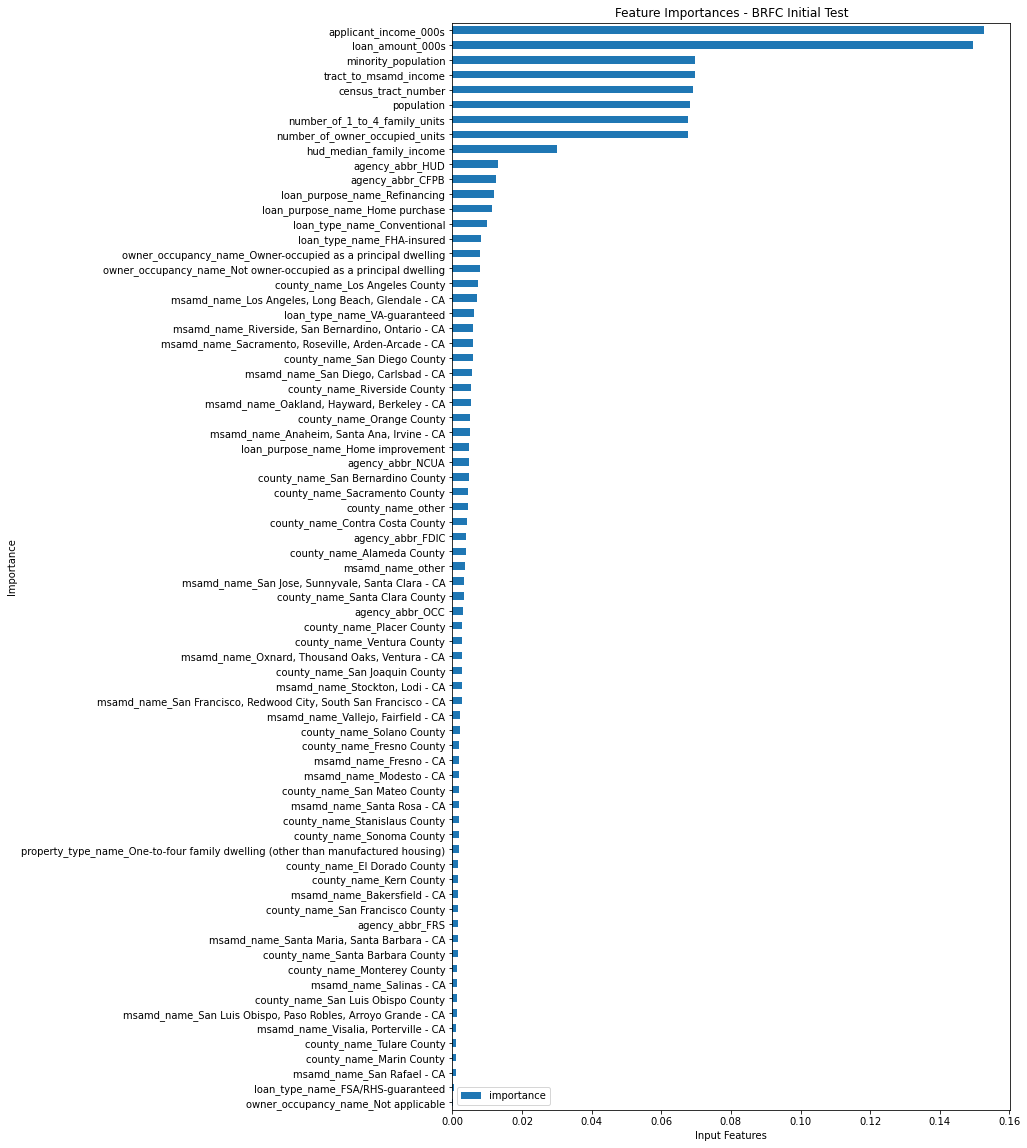

    importance                                          parameter
0     0.152631                              applicant_income_000s
1     0.149656                                   loan_amount_000s
2     0.069807                                minority_population
3     0.069710                              tract_to_msamd_income
4     0.069126                                census_tract_number
5     0.068143                                         population
6     0.067681                      number_of_1_to_4_family_units
7     0.067678                     number_of_owner_occupied_units
8     0.030189                           hud_median_family_income
9     0.013040                                    agency_abbr_HUD
10    0.012445                                   agency_abbr_CFPB
11    0.012081                      loan_purpose_name_Refinancing
12    0.011346                    loan_purpose_name_Home purchase
13    0.010048                        loan_type_name_Conventional
14    0.00

In [46]:
brfc_importances = get_feature_importances(brfc, X, file_title='brfc_0', graph_title='BRFC Initial Test', fig_size=(10,20))


Since Accuracy was so low, we need to go back and look at buckets again. let's reduce MSAMD and County to 10 buckets each

In [47]:
ml_df_1 = make_buckets(ml_df, 'msamd_name', 34500)
ml_df_1 = make_buckets(ml_df, 'county_name', 35000)

In [48]:
ml_df_1.msamd_name.value_counts()

other                                                    328971
Los Angeles, Long Beach, Glendale - CA                   305494
Riverside, San Bernardino, Ontario - CA                  222800
San Diego, Carlsbad - CA                                 138451
Sacramento, Roseville, Arden-Arcade - CA                 122260
Oakland, Hayward, Berkeley - CA                          121191
Anaheim, Santa Ana, Irvine - CA                          116302
San Jose, Sunnyvale, Santa Clara - CA                     67129
San Francisco, Redwood City, South San Francisco - CA     44549
Name: msamd_name, dtype: int64

In [49]:
ml_df_1.county_name.value_counts()

other                    422797
Los Angeles County       305494
San Diego County         138451
Riverside County         125358
Orange County            116302
San Bernardino County     97442
Sacramento County         76235
Santa Clara County        63877
Alameda County            63119
Contra Costa County       58072
Name: county_name, dtype: int64

In [50]:
ml_df_1_encoded = encode_data(ml_df_1, ml_cat)
ml_df_1_encoded.columns

encode_data: Done!


Index(['loan_amount_000s', 'applicant_income_000s', 'population',
       'minority_population', 'census_tract_number',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'action_taken', 'agency_abbr_CFPB', 'agency_abbr_FDIC',
       'agency_abbr_FRS', 'agency_abbr_HUD', 'agency_abbr_NCUA',
       'agency_abbr_OCC', 'loan_type_name_Conventional',
       'loan_type_name_FHA-insured', 'loan_type_name_FSA/RHS-guaranteed',
       'loan_type_name_VA-guaranteed',
       'property_type_name_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'owner_occupancy_name_Not applicable',
       'owner_occupancy_name_Not owner-occupied as a principal dwelling',
       'owner_occupancy_name_Owner-occupied as a principal dwelling',
       'msamd_name_Anaheim, Santa Ana, Irvine - CA',
  

In [51]:
def split_train_build_brfc(data, target, model_name, file_title, graph_title, fig_size):
  
  X_, y_ = split_target(data, target)

  X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, random_state=1, stratify=y_)

  X_train_scaled_, X_test_scaled_ = scale_data(X_train_, X_test_)

  brfc_, brfc_pred, brfc_accuracy = brfc_model(X_train_scaled_, X_test_scaled_, y_train_, y_test_)

  model_metrics(model_name=model_name, test=y_test_, pred=brfc_pred, file_title=file_title)

  brfc_importances = get_feature_importances(brfc_, X_, file_title=file_title, graph_title=graph_title, fig_size=fig_size)

  return brfc_, brfc_pred, brfc_importances

split_target: Done!
scale_data: Done!
Balanced Accuracy Score: Balanced Random Forest Classifier
Accuracy Score: 0.5343081214841927
Balanced Random Forest Model Reduced - Test 1
Accuracy Score: 0.5343
          Predicted 0  Predicted 1
Actual 0        88652        75386
Actual 1        94965       106309
                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.54      0.53      0.51      0.53      0.29    164038
          1       0.59      0.53      0.54      0.56      0.53      0.29    201274

avg / total       0.54      0.53      0.53      0.53      0.53      0.29    365312



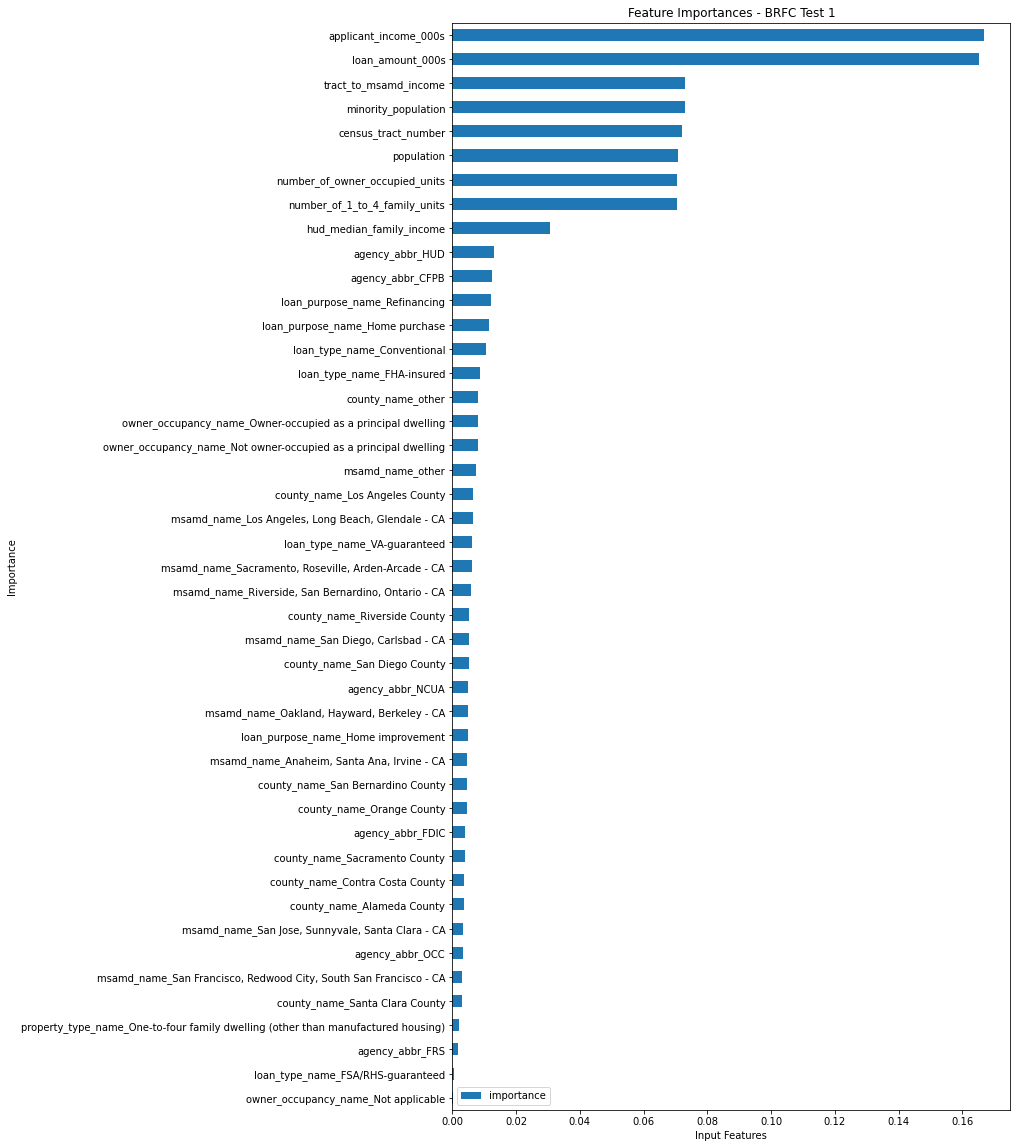

    importance                                          parameter
0     0.166746                              applicant_income_000s
1     0.165108                                   loan_amount_000s
2     0.072961                              tract_to_msamd_income
3     0.072952                                minority_population
4     0.072075                                census_tract_number
5     0.070957                                         population
6     0.070634                     number_of_owner_occupied_units
7     0.070450                      number_of_1_to_4_family_units
8     0.030582                           hud_median_family_income
9     0.012993                                    agency_abbr_HUD
10    0.012503                                   agency_abbr_CFPB
11    0.012259                      loan_purpose_name_Refinancing
12    0.011530                    loan_purpose_name_Home purchase
13    0.010427                        loan_type_name_Conventional
14    0.00

In [52]:
brfc_1, brfc_1_pred, brfc_1_importances = split_train_build_brfc(data=ml_df_1_encoded, target='action_taken', model_name='Balanced Random Forest Model Reduced - Test 1', file_title='brfc_1', graph_title='BRFC Test 1', fig_size=(10,20))

In [53]:
ml_df_2 = ml_df.copy()

In [54]:
def encode_labels(data, cat):
  data = data.copy()

  enc_data = data[cat]

  le = LabelEncoder()

  for col in enc_data.columns:
    data[col] = le.fit_transform(data[col])

  return data


In [55]:
ml_df_2_encoded = encode_labels(ml_df_2, ml_cat)
ml_df_2_encoded.columns


Index(['loan_amount_000s', 'applicant_income_000s', 'population',
       'minority_population', 'census_tract_number',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'agency_abbr', 'loan_type_name', 'property_type_name',
       'loan_purpose_name', 'owner_occupancy_name', 'msamd_name',
       'county_name', 'action_taken'],
      dtype='object')

split_target: Done!
scale_data: Done!
Balanced Accuracy Score: Balanced Random Forest Classifier
Accuracy Score: 0.5791457430073801
Balanced Random Forest Model Reduced - Test 2
Accuracy Score: 0.5791
          Predicted 0  Predicted 1
Actual 0        98017        66613
Actual 1        88360       113797
                   pre       rec       spe        f1       geo       iba       sup

          0       0.53      0.60      0.56      0.56      0.58      0.34    164630
          1       0.63      0.56      0.60      0.59      0.58      0.33    202157

avg / total       0.58      0.58      0.58      0.58      0.58      0.34    366787



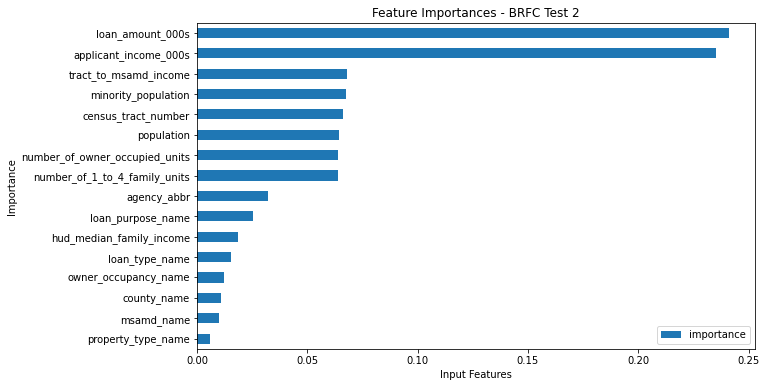

    importance                       parameter
0     0.240978                loan_amount_000s
1     0.235302           applicant_income_000s
2     0.068095           tract_to_msamd_income
3     0.067352             minority_population
4     0.066152             census_tract_number
5     0.064479                      population
6     0.064062  number_of_owner_occupied_units
7     0.063662   number_of_1_to_4_family_units
8     0.032270                     agency_abbr
9     0.025086               loan_purpose_name
10    0.018390        hud_median_family_income
11    0.015233                  loan_type_name
12    0.012180            owner_occupancy_name
13    0.010881                     county_name
14    0.010036                      msamd_name
15    0.005842              property_type_name


In [56]:
brfc_2, brfc_2_pred, brfc_2_importances = split_train_build_brfc(data=ml_df_2_encoded, target='action_taken', model_name='Balanced Random Forest Model Reduced - Test 2', file_title='brfc_2', graph_title='BRFC Test 2', fig_size=(10,6))